In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from nltools.data import Brain_Data, Design_Matrix, Adjacency
import networkx as nx
from scipy import signal
from mne_connectivity import spectral_connectivity_epochs
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io
from itertools import cycle
from matplotlib.lines import Line2D
from scipy.fft import fft, fftfreq


from functions.EpiIndex import *
from functions.Connectivity import *

In [5]:
raw=mne.io.read_raw_fif('/home/pablo/works/dev_thesis_SEEG/data/pte_01/sets/segments_ictal_SR/ictal-epo_6.fif', preload=True)
#Reading a npy file 
data1 = np.load('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/pte_01_connectivity_data_alpha_aec_dense.npy')
data2 = np.load('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/pte_01_connectivity_data_beta_aec_dense.npy')
data3 = np.load('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/pte_01_connectivity_data_high_gamma1_aec_dense.npy')
# con_data=np.mean(data,axis=3)
# ch_names = raw.info['ch_names']

Opening raw data file /home/pablo/works/dev_thesis_SEEG/data/pte_01/sets/segments_ictal_SR/ictal-epo_6.fif...
Isotrak not found
    Range : 4681728 ... 4866048 =   9144.000 ...  9504.000 secs
Ready.
Reading 0 ... 184320  =      0.000 ...   360.000 secs...


/tmp/ipykernel_3787/3082976561.py:1: RuntimeWarning: This filename (/home/pablo/works/dev_thesis_SEEG/data/pte_01/sets/segments_ictal_SR/ictal-epo_6.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw=mne.io.read_raw_fif('/home/pablo/works/dev_thesis_SEEG/data/pte_01/sets/segments_ictal_SR/ictal-epo_6.fif', preload=True)


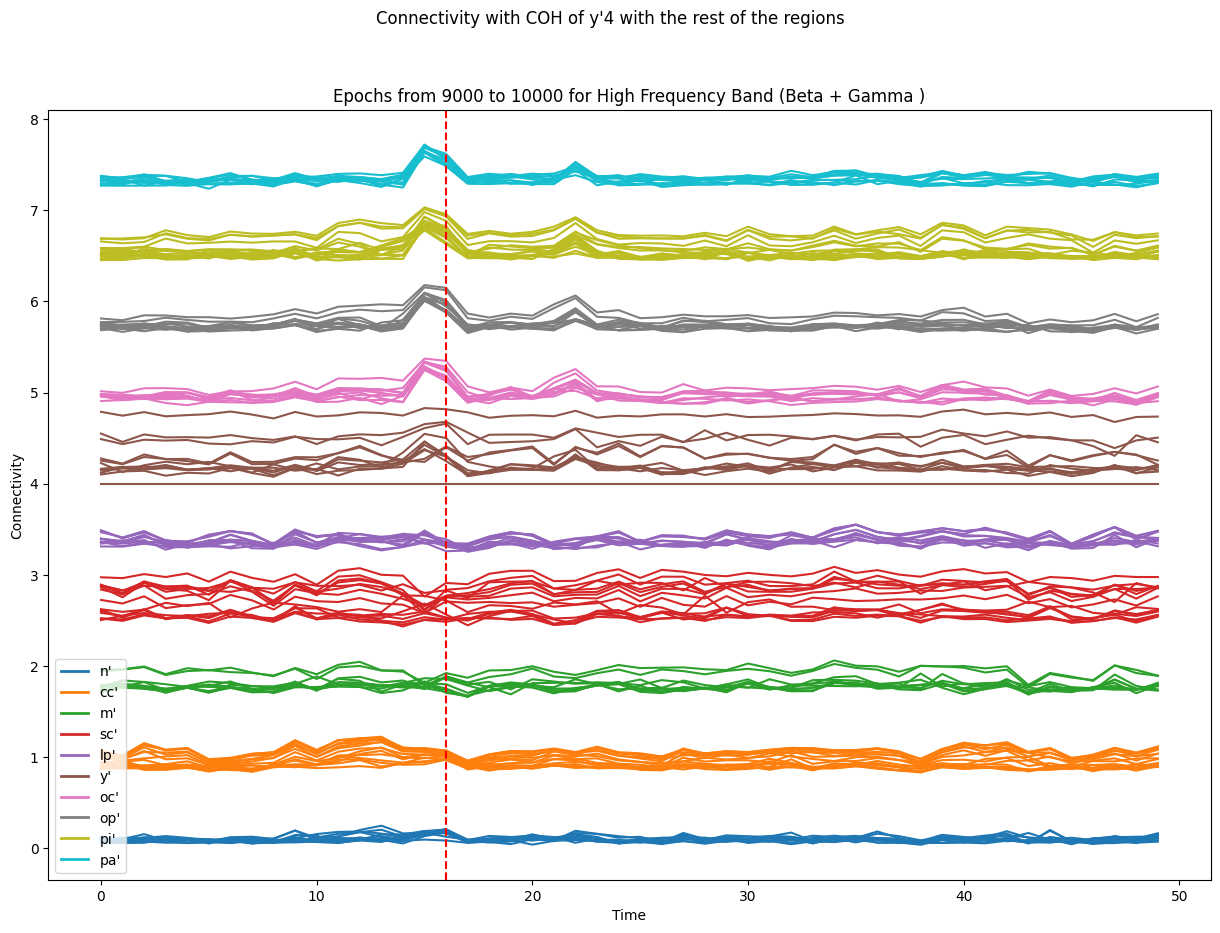

In [16]:
total_epochs=con_data.shape[0]
real_time_crisis=(2*60*60)+35*60+27
t_0=9000
t_1=10000
window_size=(t_1-t_0)/total_epochs
#Calculate the epoch of the crisis
crisis_epoch=int((real_time_crisis-t_0)/window_size)


# Make sure the matrix is symmetric
#If not, make it symmetric using the lower triangle
Connectivity_matrixes = con_data
N_mat=Connectivity_matrixes.shape[0]
for i in range(N_mat):
    if not np.allclose(Connectivity_matrixes[i,:,:], Connectivity_matrixes[i,:,:].T, atol=1e-8):
        Connectivity_matrixes[i,:,:] = np.tril(Connectivity_matrixes[i,:,:]) + np.tril(Connectivity_matrixes[i,:,:], -1).T
    else:
        continue


#Now, using the index of every channel, we are going ton generate the corresponding plots for every region
# Get the matrixes which consider the interested channel, e.g. the channel sc'1, 
# and the rest of the channels
#First, get all the rows, for the 150 matrixes
channel_name="y'4"
method="COH"
# channel_name="CC01"
channel_index=ch_names.index(channel_name)
#Get the rows
rows=Connectivity_matrixes[:,channel_index,:]
regions=["n'","cc'","m'","sc'","lp'","y'","oc'","op'","pi'","pa'"]
# regions=[ 'OF', 'CR', 'CA', 'CC', 'SC', 'OP', 'IP', 'PM', 'SA', 'CP', 'PA', 'I', 'B', 'C']
#Get the index of every region checking if the regions is in the name of the channel
regions_index=[]
for region in regions:
    for i in range(len(ch_names)):
        if region in ch_names[i]:
            regions_index.append(i)
            break

#Generate labels for the regions
labels=[]
for i in ch_names:
    for region in regions:
        if region in i:
            labels.append(region)
            break 


color_cycle = cycle(plt.cm.tab10.colors)  # Cycle through a colormap
colors = {label: next(color_cycle) for label in regions}

# Plot each group of channels
plt.figure(figsize=(15, 10))

# Offset step to separate different label groups on the y-axis
offset_step = 0.8
current_offset = 0

for label in regions:
    indices = [i for i, l in enumerate(labels) if l == label]
    for i in indices:
        plt.plot(rows[:, i] + current_offset, label=f'{labels[i]} (Channel {i})', color=colors[label])
    current_offset += offset_step

# Create custom legend handles
legend_handles = [Line2D([0], [0], color=colors[label], lw=2, label=label) for label in regions]

#plot a vertical dotted line in the crisis epoch
plt.axvline(x=crisis_epoch, color='r', linestyle='--')
# Add the custom legend to the plot
plt.legend(handles=legend_handles)
plt.suptitle(f'Connectivity with {method} of {channel_name} with the rest of the regions')
#Put a subtitle
plt.title(f'Epochs from {t_0} to {t_1} for High Frequency Band (Beta + Gamma )')
plt.xlabel('Time')
plt.ylabel('Connectivity')
plt.show()

MovieWriter imagemagick unavailable; using Pillow instead.


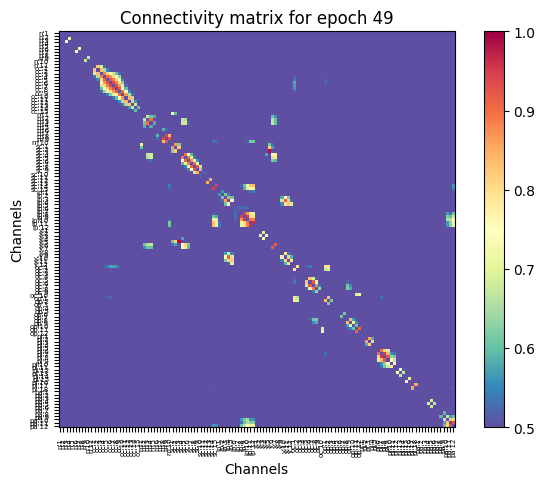

In [23]:
#Make an animation of the connectivity matrixes for every i_epoch
# Initialize the figure
fig, ax = plt.subplots()
# Initialize the image object
im = ax.imshow(Connectivity_matrixes[0,:,:], cmap='Spectral_r',vmax=1, vmin=0.5)
# Set the title
# Set the x-axis label
ax.set_xlabel('Channels')
# Set the y-axis label
ax.set_ylabel('Channels')
# Set the x-axis ticks
ax.set_xticks(range(len(ch_names)))
# Set the x-axis tick labels
ax.set_xticklabels(ch_names, rotation=90)
# Set the y-axis ticks
ax.set_yticks(range(len(ch_names)))

# Set the y-axis tick labels
ax.set_yticklabels(ch_names)
# Set the colorbar
fig.colorbar(im)
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
# Set the tight layout
plt.tight_layout()

# Function to update the image
def update(i):
    im.set_data(Connectivity_matrixes[i,:,:])
    ax.set_title(f'Connectivity matrix for epoch {i}')
    return im
# Create the animation
ani = animation.FuncAnimation(fig, update, frames=range(N_mat), interval=200)
# Save the animation
ani.save('connectivity.gif', writer='imagemagick')
# Show the animation
plt.show()


Adjacency matrix for PLV matrix


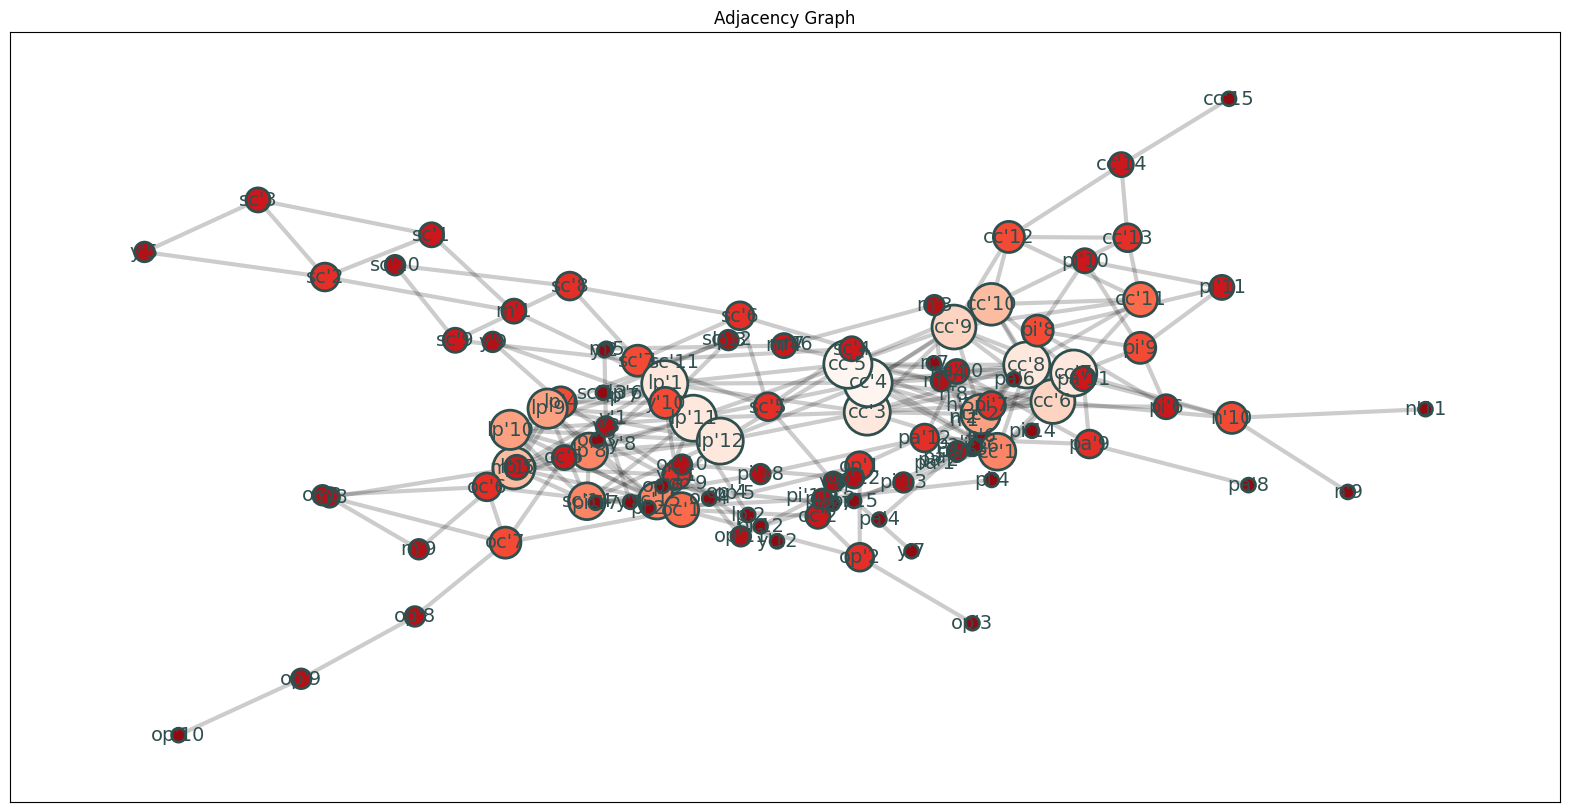

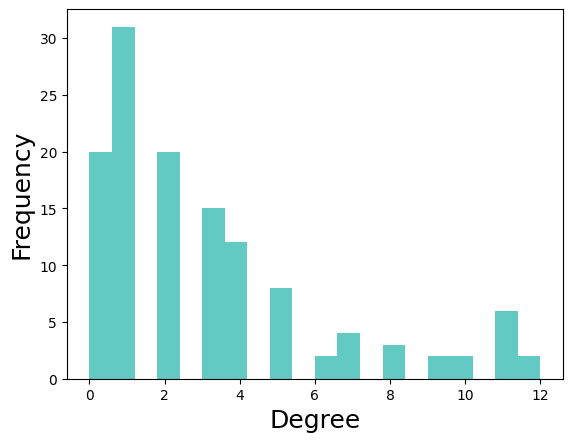

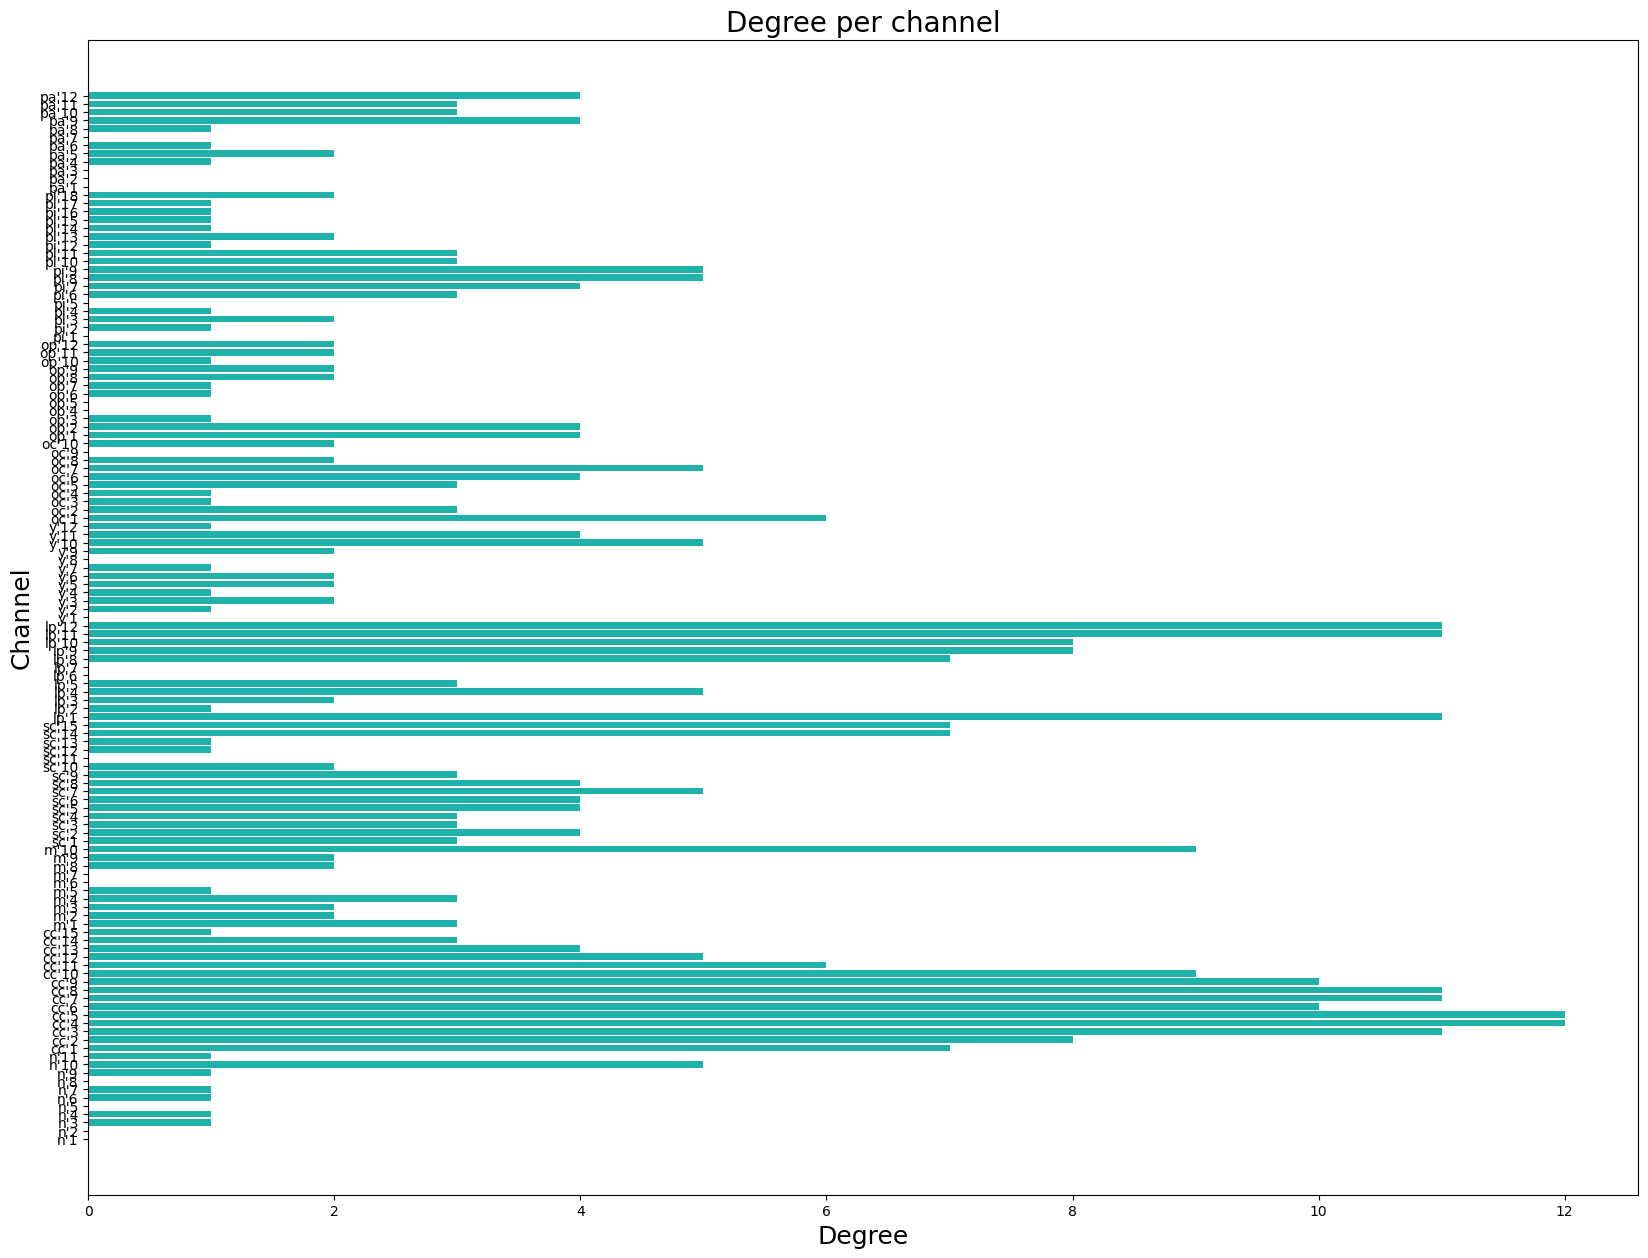

In [14]:
a_thresholded,G=compute_adjacency_graph(raw,Connectivity_matrixes[crisis_epoch,:,:],"PLV",threshold=0.5)

In [ ]:
a_thresholded,G=compute_adjacency_graph(raw,Connectivity_matrixes[crisis_epoch,:,:],"COH",threshold=0.7)
#MAke an animation of the graph and the degree histogram for every i_epoch
# Initialize the figure
node_and_degree = G.degree()
pos = nx.kamada_kawai_layout(G)
fig, axs = plt.subplots()
#size of the figure
fig.set_size_inches(20, 15)
# Initialize the image object
im = axs.barh(list(dict(G.degree).keys()), list(dict(G.degree).values()), color='lightseagreen')
# Set the title
axs.set_title('Degree Histogram per channel')
# Set the x-axis label
axs.set_xlabel('Degree',fontsize=18)
# Set the y-axis label
axs.set_ylabel('Channel',fontsize=18)
#Naming the channels
axs.set_yticks(range(len(ch_names)))
# Set the tight layout
plt.tight_layout()
# Function to update the image
def update(i):
    a_thresholded,G=compute_adjacency_graph(raw,Connectivity_matrixes[i,:,:],"COH",threshold=0.7)
    im = axs.barh(list(dict(G.degree).keys()), list(dict(G.degree).values()), color='lightseagreen')
    axs.set_title('Degree Histogram per channel in epoch '+str(i))
    return im
# Create the animation
ani = animation.FuncAnimation(fig, update, frames=range(N_mat), interval=200)
# Save the animation
ani.save('degree.gif', writer='imagemagick')